In [1]:
from mistralai.client import MistralClient

client = MistralClient('')

In [2]:
import pandas as pd

df = pd.read_csv('data1.csv')
df.head()

,Sentence,Topic
0,Dogs are known as man's best friend.,Dogs
1,My dog loves playing fetch in the backyard,Dogs
2,Some dogs are trained to assist people with di...,Dogs
3,Labrador Retrievers are popular for their frie...,Dogs
4,Puppies require a lot of attention and care,Dogs


In [3]:
df['Topic'].unique()

array(['Dogs', 'Football', 'Cuisine', 'Travel', 'Technology', 'Movies',
       'Books', 'Music', 'Gaming', 'Environment', 'Education', 'Fashion'],
      dtype=object)

In [4]:
# topics = {'Dogs':0,'Football':1,'Cuisine':2,'Travel':3,'Technology':4,'Movies':5,'Books':6,'Music':7,'Gaming':8,'Environment':9,'Education':10,'Fashion':11}
# df['Topic'] = df['Topic'].map(topics)
# df.head()

In [5]:
def only_alphanum(text:str) -> str:
    out_text = ''
    for char in text:
        if char.isalnum() == True:
            out_text += char
    return out_text

def unique_list(list_texts:list[str]) -> list[str]:
    is_alreay_take = {}
    new_list:list[str] = []
    for text in list_texts:
        temp_text = only_alphanum(text.lower())
        if is_alreay_take.get(temp_text, False) == False:
            new_list.append(text)
            is_alreay_take[temp_text] = True
    return new_list

text = df['Sentence'].to_list()
data = unique_list(text)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def get_text_embedding(text):
    embeddings = client.embeddings(model = "mistral-embed", input=text).data[0].embedding
    return embeddings

# print(get_text_embedding(data[0]))

In [8]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [client.embeddings(model="mistral-embed", input=c) for c in chunks]
    embeddings = []
    for i in range(len(embeddings_response)):
        for d in embeddings_response[i].data:
            embeddings.append(d.embedding)
    return embeddings



In [9]:
# df1 = pd.DataFrame(data, columns=['Sentence'])
# df1.head()

In [10]:
df['embedding'] = get_embeddings_by_chunks(df['Sentence'].tolist(), 1000)
# df1.to_csv('data_with_embeddings.csv', index=False)
df.head()

,Sentence,Topic,embedding
0,Dogs are known as man's best friend.,Dogs,"[0.0005736351013183594, -0.036590576171875, 0...."
1,My dog loves playing fetch in the backyard,Dogs,"[-0.028839111328125, 0.00765228271484375, 0.01..."
2,Some dogs are trained to assist people with di...,Dogs,"[-0.024169921875, 0.01540374755859375, 0.01120..."
3,Labrador Retrievers are popular for their frie...,Dogs,"[0.0041656494140625, -0.004886627197265625, 0...."
4,Puppies require a lot of attention and care,Dogs,"[-0.055419921875, -0.003292083740234375, 0.037..."


In [11]:
# df1 = pd.read_csv('data_with_embeddings.csv')

In [12]:
embeddings = df['embedding'].to_list()
embeddings_np = np.array(embeddings).astype('float32')

In [13]:
print(embeddings[0])

[0.0005736351013183594, -0.036590576171875, 0.032257080078125, -0.0119476318359375, 0.013946533203125, -0.0037555694580078125, 0.05389404296875, -0.02197265625, 0.004993438720703125, -0.0281219482421875, -0.0164794921875, 0.0252227783203125, -0.01739501953125, 0.036712646484375, -0.0499267578125, 0.02825927734375, 0.01557159423828125, 0.01073455810546875, 0.0411376953125, 0.0245361328125, -0.006053924560546875, -0.01448822021484375, -0.023834228515625, 0.0152740478515625, -0.034637451171875, 0.0004303455352783203, -0.0030841827392578125, -0.040435791015625, -0.00951385498046875, 0.024932861328125, -0.011749267578125, -0.036407470703125, -0.00789642333984375, -0.00408935546875, 0.042694091796875, -0.07049560546875, -0.01800537109375, -0.0291595458984375, 0.0221710205078125, 0.005931854248046875, -0.030670166015625, -0.041412353515625, 0.017486572265625, 0.020843505859375, 0.0029582977294921875, -0.0491943359375, -0.01139068603515625, -0.020751953125, 0.023193359375, 0.00594329833984375,

In [14]:
# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(data, sent):
    similarities = cosine_similarity(embeddings_np, np.array(get_text_embedding(sent)).reshape(1, -1))
    # print(len(data))
    cosine_similarities = similarities.flatten()
    max_similarities = cosine_similarities.argsort()[-6:][::-1]

    for i in max_similarities:
            print("Sentence:", data[i])
            # print("Cosine Similarity:", cosine_similarities[i])
            # print(embeddings_np[i])


    # return [(data[i], cosine_similarities[i]) for i in max_similarities]

    return [(data[i], cosine_similarities[i]) for i in max_similarities]

print(get_cosine_similarity(data, data[1]))

Sentence: My dog loves playing fetch in the backyard
Sentence: Walking my dog is a daily routine I enjoy
Sentence: Dog parks provide a great opportunity for socialization
Sentence: Training a dog requires patience and consistency
Sentence: Adopting a rescue dog can be a rewarding experience
Sentence: Some dogs are trained to assist people with disabilities
[('My dog loves playing fetch in the backyard', 0.99999944496552), ('Walking my dog is a daily routine I enjoy', 0.7948213672586134), ('Dog parks provide a great opportunity for socialization', 0.7288909804638843), ('Training a dog requires patience and consistency', 0.7202682986146004), ('Adopting a rescue dog can be a rewarding experience', 0.7121477420395963), ('Some dogs are trained to assist people with disabilities', 0.7086367125234754)]


In [15]:
import numpy as np

In [16]:
# Faiss Search
import faiss

embeddings_np = np.array(embeddings).astype('float32')
d = embeddings_np.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings_np)

def faiss_search(sent, k=6):
    query_embed = get_text_embedding(sent)
    query_embed = np.array(query_embed).astype('float32').reshape(1, -1)
    D, I = index.search(query_embed, k)
    sentences = [data[i] for i in I[0]]
    return sentences


print(faiss_search(data[1]))


['My dog loves playing fetch in the backyard', 'Walking my dog is a daily routine I enjoy', 'Dog parks provide a great opportunity for socialization', 'Training a dog requires patience and consistency', 'Adopting a rescue dog can be a rewarding experience', 'Some dogs are trained to assist people with disabilities']


## Clustering

## Hierarchical clustering

In [17]:
Y = df['Topic']

In [18]:
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=42)

ypred = clust.fit_predict(embeddings_np)
labels = clust.labels_
print(labels)

[ 9  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 11 11 11 11 11 11 11 11 11 11  3 11  3 11  5  5  5  5  5  5  3
  5  5  3  5 10  5  5  2  2  2  8  2  2  2  2  2  2  4  2  2  6  2  4  4
  4  4  4  4  1  3  4  4  4  6  4  4  5  4  4  4  4  4  1  4  7  7  1  4
  2  7  1  3  3  1  1  1  1  1  3  1  3  1  3  1  1  8  8  8  8  8  8  8
  8  8  8  8  8  8 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7  7
  7  7  6 10  6  6  6  6  6  6  6  6]


In [19]:
df['Cluster'] = labels
df.head()

,Sentence,Topic,embedding,Cluster
0,Dogs are known as man's best friend.,Dogs,"[0.0005736351013183594, -0.036590576171875, 0....",9
1,My dog loves playing fetch in the backyard,Dogs,"[-0.028839111328125, 0.00765228271484375, 0.01...",9
2,Some dogs are trained to assist people with di...,Dogs,"[-0.024169921875, 0.01540374755859375, 0.01120...",9
3,Labrador Retrievers are popular for their frie...,Dogs,"[0.0041656494140625, -0.004886627197265625, 0....",9
4,Puppies require a lot of attention and care,Dogs,"[-0.055419921875, -0.003292083740234375, 0.037...",9


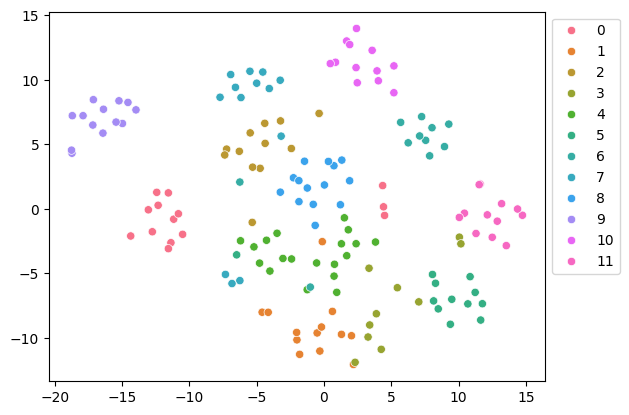

In [20]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embedding'].to_list()))

palette = sns.color_palette("husl", len(df['Cluster'].unique()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['Cluster'].to_list()), palette=palette)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [21]:
# from sklearn import metrics
# # Convert  labels_np to numerical values if necessary

# label = pd.Series(Y).astype('category').cat.codes
# label_np = label.to_numpy()
# labels_np=np.array(labels)
# # label_np= df['Topic'].cat.codes
# # print( labels_np)
# # print(labels_np)

# print("Homogeneity: %0.3f" % metrics.homogeneity_score(label,labels))
# print("Completeness: %0.3f" % metrics.completeness_score(label,labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(label,labels))
# print("Adjusted Rand-Index: %.3f"
#       % metrics.adjusted_rand_score(label,labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(embeddings_np,labels, sample_size=1000))


In [22]:
for labels, text in zip(labels, data):
    print(labels, text)

9 Dogs are known as man's best friend.
9 My dog loves playing fetch in the backyard
9 Some dogs are trained to assist people with disabilities
9 Labrador Retrievers are popular for their friendly demeanor
9 Puppies require a lot of attention and care
9 Walking my dog is a daily routine I enjoy
9 Dog parks provide a great opportunity for socialization
9 Dog owners should be responsible for cleaning up after their pets
9 Training a dog requires patience and consistency
9 Dog grooming is an important part of pet care
9 Adopting a rescue dog can be a rewarding experience
9 Dog training classes help improve obedience and behavior.
9 Dog breeds vary widely in size, temperament, and energy levels
0 Football, or soccer, is the most popular sport worldwide.
0 Lionel Messi is considered one of the greatest footballers of all time
0 Watching a live football match at the stadium is exhilarating.
0 The World Cup is held every four years and attracts millions of viewers.
0 Football players often hav

In [23]:
# Descending Clustering
from sklearn.cluster import AgglomerativeClustering

clf = AgglomerativeClustering(n_clusters=None, metric='euclidean', memory=None, connectivity=None, compute_full_tree=True, linkage='ward', distance_threshold=1, compute_distances=False)
clf.fit(embeddings_np)

labels1 = clf.labels_
print(labels1)
df['Cluster1'] = labels1
df.head()

[ 1  1  1  1  1  1  1  1  1  1  1  1  1 12  5  5 12  5  5  5  5  5  5  5
  5  5  5  9  9  9  9  9  9  9  9  9  9  9  9  9  9  6  6  6  6  6  6 12
  6  6  6  6  3  6  6  0 10  0 10  0  0  0  0  0  0  0  0  0  0  0 12  2
  2  2  2  2  2  2  2  2  2  2  2  2  7  7  2  2  2  7  7  7  7  7  7  7
  0  7  4  4  4  4  4  4  4  2  4  4  4  4  4  4  4 12 10 10 10 12 10 10
 10 10 10  2  2 10  3  3  3  3  3  3  3  3  3  3 11 11 11  0 11 11 11 11
 11 11  8  3  8  8  8  8  8  8  8  8]


,Sentence,Topic,embedding,Cluster,Cluster1
0,Dogs are known as man's best friend.,Dogs,"[0.0005736351013183594, -0.036590576171875, 0....",9,1
1,My dog loves playing fetch in the backyard,Dogs,"[-0.028839111328125, 0.00765228271484375, 0.01...",9,1
2,Some dogs are trained to assist people with di...,Dogs,"[-0.024169921875, 0.01540374755859375, 0.01120...",9,1
3,Labrador Retrievers are popular for their frie...,Dogs,"[0.0041656494140625, -0.004886627197265625, 0....",9,1
4,Puppies require a lot of attention and care,Dogs,"[-0.055419921875, -0.003292083740234375, 0.037...",9,1


In [24]:
topic = df['Topic'].to_list()

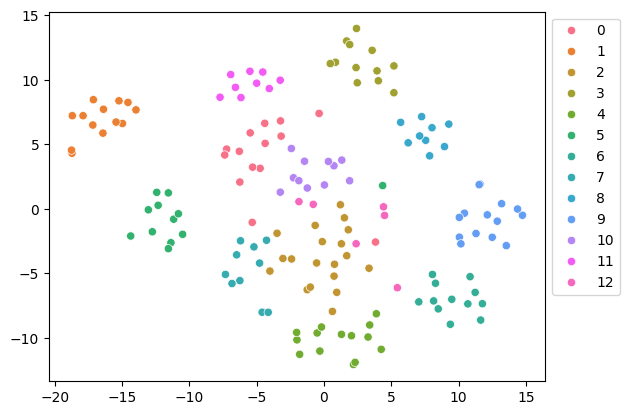

In [25]:
palette = sns.color_palette("husl", len(df['Cluster1'].unique()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['Cluster1'].to_list()), palette=palette)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [26]:
for labels1, text in zip(labels1, data):
    print(labels1, text)

1 Dogs are known as man's best friend.
1 My dog loves playing fetch in the backyard
1 Some dogs are trained to assist people with disabilities
1 Labrador Retrievers are popular for their friendly demeanor
1 Puppies require a lot of attention and care
1 Walking my dog is a daily routine I enjoy
1 Dog parks provide a great opportunity for socialization
1 Dog owners should be responsible for cleaning up after their pets
1 Training a dog requires patience and consistency
1 Dog grooming is an important part of pet care
1 Adopting a rescue dog can be a rewarding experience
1 Dog training classes help improve obedience and behavior.
1 Dog breeds vary widely in size, temperament, and energy levels
12 Football, or soccer, is the most popular sport worldwide.
5 Lionel Messi is considered one of the greatest footballers of all time
5 Watching a live football match at the stadium is exhilarating.
12 The World Cup is held every four years and attracts millions of viewers.
5 Football players often h

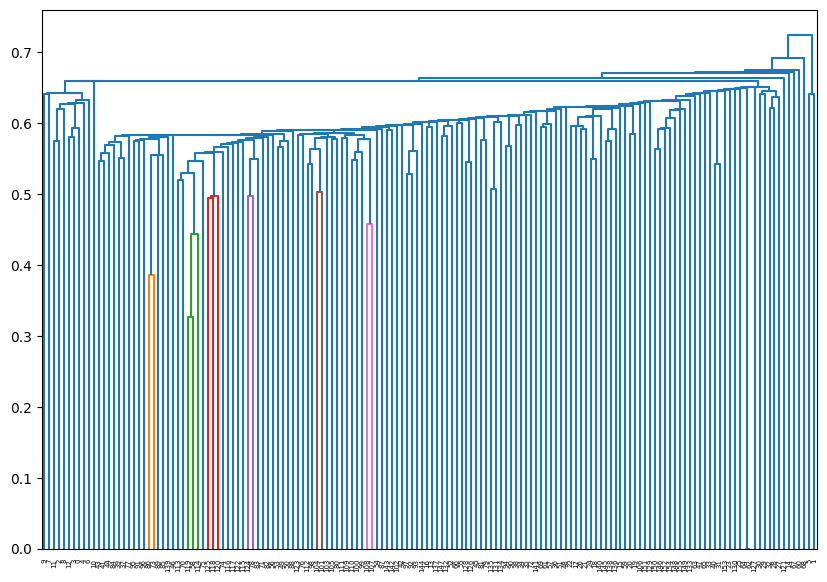

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(embeddings_np, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

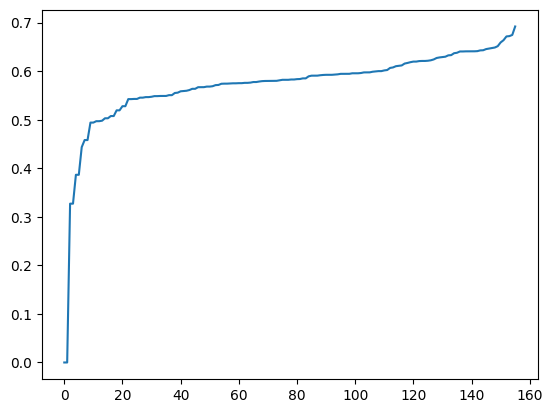

In [45]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(embeddings_np)
distances, indices = nbrs.kneighbors(embeddings_np)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [50]:
from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=0.7, min_samples=4)
ypred = clf.fit_predict(embeddings_np)
labels2 = clf.labels_
df['Cluster2'] = labels2
print(labels2)

[ 0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


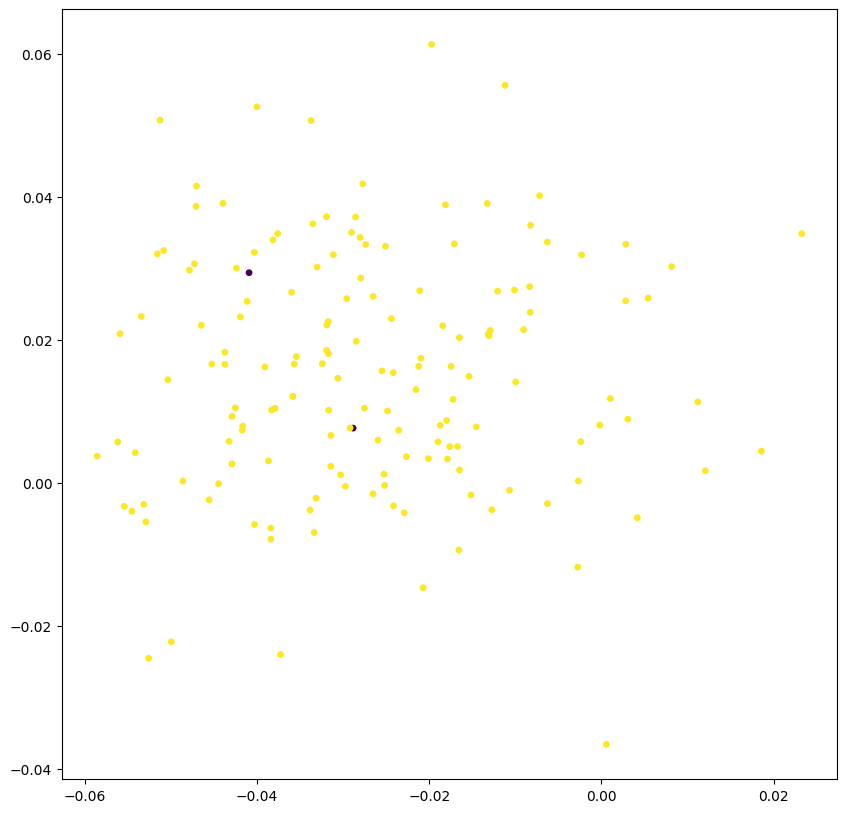

In [51]:
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c=labels2, cmap='viridis', s=15)

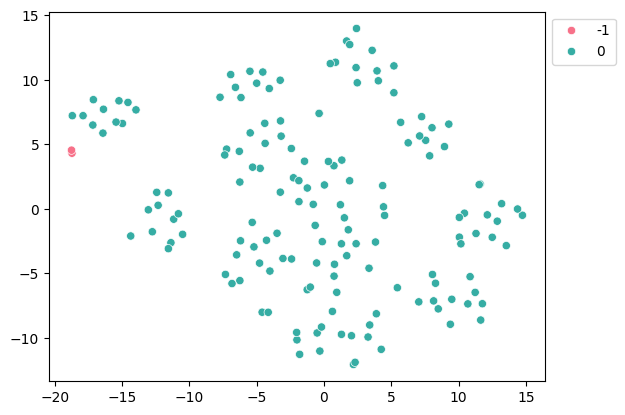

In [52]:
palette = sns.color_palette("husl", len(df['Cluster2'].unique()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['Cluster2'].to_list()), palette=palette)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [55]:
# OPTICS 
from sklearn.cluster import OPTICS

cluster = OPTICS(min_samples=4)
ypred = cluster.fit_predict(embeddings_np)
labels3 = cluster.labels_
print(labels3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
